# Loan Prediction System

In [1]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import joblib
import ipywidgets as widgets
from IPython.display import display
import tkinter as tk
from tkinter import ttk, messagebox
import pandas as pd

In [3]:
data= pd.read_csv('../res/loan-dataset.csv')
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y



## Data Cleaning

### Finding NULL values count

We should first see how many rows do we have that are null in each column

In [4]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Statistically speaking, we don't need to remove NULL values from these column because they don't have any or they are not so important for data processing:
- Loan_ID
- Education
- ApplicantIncome
- CoapplicantIncome
- Property_Area
- Loan_Status

### Filling in Missing Values

We will fill the missing values for the columns as follows:

* LoanAmount: median
* Loan_Amount_Term: median
* Gender: mode
* Married: mode
* Dependents: mode
* Self_Employed: mode
* Credit_History: mode

#### LoanAmount

In [5]:
print("max: ", data['LoanAmount'].max())
print("min: ", data['LoanAmount'].min())
print("mean: ", data['LoanAmount'].mean())
print("median: ", data['LoanAmount'].median())
print("standard deviation: ", data['LoanAmount'].std())

max:  700.0
min:  9.0
mean:  146.41216216216216
median:  128.0
standard deviation:  85.58732523570545


In [6]:
data['LoanAmount'].fillna(data['LoanAmount'].median(), inplace=True)

/tmp/ipykernel_9763/4230643855.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['LoanAmount'].fillna(data['LoanAmount'].median(), inplace=True)


#### Loan_Amount_Term

In [7]:
print("max: ", data['Loan_Amount_Term'].max())
print("min: ", data['Loan_Amount_Term'].min())
print("mean: ", data['Loan_Amount_Term'].mean())
print("median: ", data['Loan_Amount_Term'].median())
print("standard deviation: ", data['Loan_Amount_Term'].std())

max:  480.0
min:  12.0
mean:  342.0
median:  360.0
standard deviation:  65.12040985461256


In [8]:
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].median(), inplace=True) 

/tmp/ipykernel_9763/2180471732.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].median(), inplace=True)


#### Categorical Column

Mode of the columns are chosen.

In [9]:
data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
data['Married'].fillna(data['Married'].mode()[0], inplace=True)
data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)
data['Self_Employed'].fillna(data['Self_Employed'].mode()[0], inplace=True)
data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace=True)

/tmp/ipykernel_9763/4185035625.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
/tmp/ipykernel_9763/4185035625.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

We will now check if NULL values are remove

In [10]:
data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Yes, NULL values have been dealt with.

### Duplicate Rows

We should check if any duplicate rows exist.

In [11]:
duplicates = data.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


No duplicate rows exist.
We don't need to safeguard against it.

### Generating Efficient Columns for AI Models

Since AI models can't directly interpret text or categorical data, we can help make that efficient.

We can transform the each category in the specified column into new binary columns.
For example, if a category can only take two values like 'Gender' which takes 'Male' or 'Female', we can transform that into a boolean value.

For example:
Gender_Male: which can be 0 or 1 depending on the value.


In [12]:
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
print(data_encoded.head())

    Loan_ID  ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0  LP001002             5849                0.0       128.0             360.0   
1  LP001003             4583             1508.0       128.0             360.0   
2  LP001005             3000                0.0        66.0             360.0   
3  LP001006             2583             2358.0       120.0             360.0   
4  LP001008             6000                0.0       141.0             360.0   

   Credit_History Loan_Status  Gender_Male  Married_Yes  Dependents_1  \
0             1.0           Y         True        False         False   
1             1.0           N         True         True          True   
2             1.0           Y         True         True         False   
3             1.0           Y         True         True         False   
4             1.0           Y         True        False         False   

   Dependents_2  Dependents_3+  Education_Not Graduate  Self_Employed_Yes 

### Removing Unnecessay Columns

We should remove any column that is not useful for our computation:

- Loan_ID

In [13]:
data_encoded = data_encoded.drop(['Loan_ID'], axis=1)
print(data_encoded.columns)

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Gender_Male',
       'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+',
       'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban'],
      dtype='object')


### Make Column Values More Comprehendable

Instead of some values representing results, we can use words to describe them.

* In Loan_Status, instead of 0 and 1, we can have 'yes' and 'no' to make them more comprehendable.

In [14]:
data_encoded['Loan_Status'] = data_encoded['Loan_Status'].map({'Y': 1, 'N': 0})
print(data_encoded['Loan_Status'].value_counts())

Loan_Status
1    422
0    192
Name: count, dtype: int64


As we can see there are 

- 422 rows: 1 to 'yes'
- 192 rows: 0 to 'no'

### Adding New Features

In [15]:
# Merge engineered features into encoded dataset
data_encoded['TotalIncome'] = data['ApplicantIncome'] + data['CoapplicantIncome']
data_encoded['EMI'] = data['LoanAmount'] / data['Loan_Amount_Term']
data_encoded['BalanceIncome'] = data_encoded['TotalIncome'] - data_encoded['EMI']
data_encoded['LoanToIncome'] = data['LoanAmount'] / data_encoded['TotalIncome']
data_encoded['IncomePerDependent'] = data_encoded['TotalIncome'] / (data['Dependents'].replace('3+', 3).astype(int) + 1)
data_encoded['LoanAmount_log'] = np.log(data['LoanAmount'] + 1)
data_encoded['TotalIncome_log'] = np.log(data_encoded['TotalIncome'] + 1)

We can now remove the first column of the dataset.

In [16]:
X = data_encoded.drop(['Loan_Status'], axis=1)
y = data_encoded['Loan_Status']

#### Split Data into Training and Testing

We train the model with 491 features and test the model with 123 features.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)

Training features shape: (491, 21)
Testing features shape: (123, 21)


## Training the Model

### Random Forest

RandomForest is a supervised machine learning model, used for classification tasks - it predicts categories or labels.
We will now train the model using our training data using the RandomForest machine learning model.

In [18]:
final_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
final_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

Why 42? because we want to control the randomness of the model and to give more consistent results.

### Testing the Model

We will now test the model with the testing data.

In [19]:

y_pred_final = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

### Information from the Training

In [20]:
accuracy = accuracy_score(y_test, y_pred_final)

print("Classification Report:\n", classification_report(y_test, y_pred_final))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.74      0.80        38
           1       0.89      0.95      0.92        85

    accuracy                           0.89       123
   macro avg       0.88      0.84      0.86       123
weighted avg       0.89      0.89      0.88       123

Confusion Matrix:
 [[28 10]
 [ 4 81]]
ROC AUC Score: 0.8572755417956657


_The model's accuracy is 78 precent_

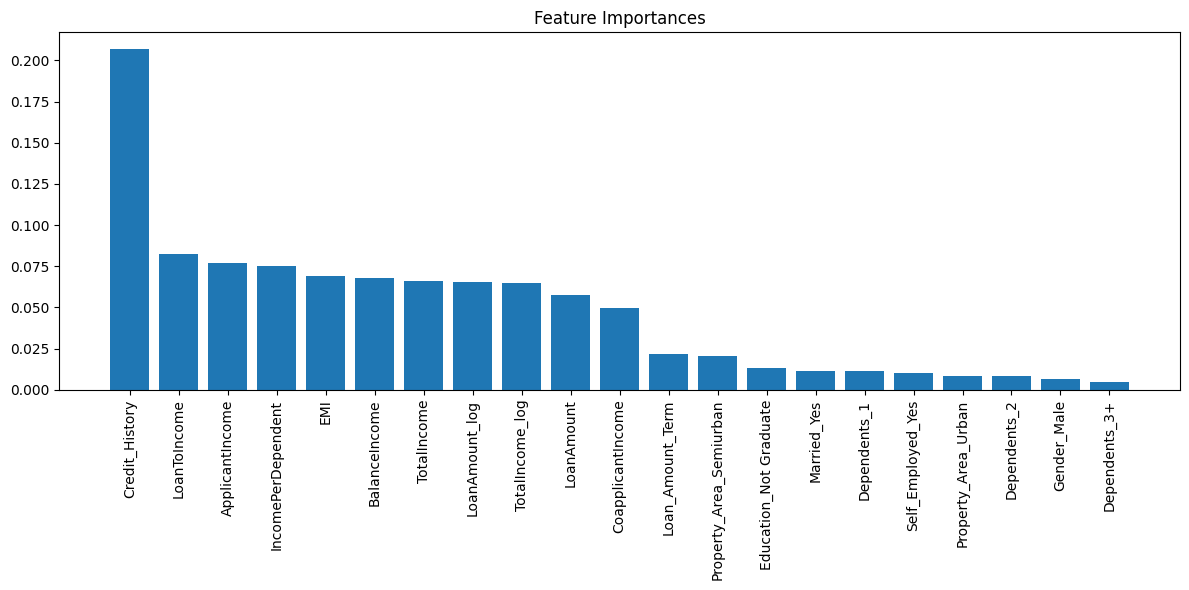

In [21]:
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

### Output

We can now use this knowledge to our advantage.
As we can see from the real world, credit history actually is important. If someone doesn't have a good credit history, they will be denied their loan.

### Storing the Model in Disk

We will dump the model onto the disk and load it to ensure it reusable across different applications

In [22]:
joblib.dump(final_model, "loan_prediction_model.pkl")

['loan_prediction_model.pkl']

The model has been stored on the disk!!!

### Loading the Model

We will now load the model from the disk.

In [23]:
loaded_model = joblib.load("loan_prediction_model.pkl")
print(loaded_model.feature_names_in_)

['ApplicantIncome' 'CoapplicantIncome' 'LoanAmount' 'Loan_Amount_Term'
 'Credit_History' 'Gender_Male' 'Married_Yes' 'Dependents_1'
 'Dependents_2' 'Dependents_3+' 'Education_Not Graduate'
 'Self_Employed_Yes' 'Property_Area_Semiurban' 'Property_Area_Urban'
 'TotalIncome' 'EMI' 'BalanceIncome' 'LoanToIncome' 'IncomePerDependent'
 'LoanAmount_log' 'TotalIncome_log']


### Getting Input about User

We will ask the user for information that is relevant for the model.

In [24]:
# Expected column order
expected_columns = [
    'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
    'Loan_Amount_Term', 'Credit_History', 'Gender_Male',
    'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+',
    'Education_Not Graduate', 'Self_Employed_Yes',
    'Property_Area_Semiurban', 'Property_Area_Urban',
    'TotalIncome', 'EMI', 'BalanceIncome', 'LoanToIncome',
    'IncomePerDependent', 'LoanAmount_log', 'TotalIncome_log'
]


def submit():
    try:
        gender = gender_var.get().lower()
        married = married_var.get().lower()
        education = education_var.get().lower()
        property_area = property_area_var.get().lower()
        credit_history = credit_var.get().lower()
        dependents = dependents_var.get()
        self_employed = self_emp_var.get().lower()

        loan_amount = int(loan_amount_var.get())
        income = int(income_var.get())
        coapp_income = int(coapp_income_var.get())
        
        total_income = income + coapp_income
        emi = loan_amount / 360
        balance_income = total_income - emi
        loan_to_income = loan_amount / total_income if total_income != 0 else 0
        dependents_numeric = 3 if dependents == '3+' else int(dependents)
        income_per_dep = total_income / (dependents_numeric + 1)
        loanamount_log = np.log(loan_amount + 1)
        totalincome_log = np.log(total_income + 1)

        user_data = pd.DataFrame({
            'Gender_Male': [1 if gender == 'male' else 0],
            'Married_Yes': [1 if married == 'yes' else 0],
            'Education_Not Graduate': [1 if education == 'not graduated' else 0],
            'Property_Area_Semiurban': [1 if property_area == 'semiurban' else 0],
            'Property_Area_Urban': [1 if property_area == 'urban' else 0],
            'Credit_History': [1 if credit_history == 'yes' else 0],
            'Self_Employed_Yes': [1 if self_employed == 'yes' else 0],
            'Dependents_1': [1 if dependents == '1' else 0],
            'Dependents_2': [1 if dependents == '2' else 0],
            'Dependents_3+': [1 if dependents == '3+' else 0],
            'ApplicantIncome': [income],
            'CoapplicantIncome': [coapp_income],
            'LoanAmount': [loan_amount],
            'Loan_Amount_Term': [360],
            'TotalIncome': [total_income],
            'EMI': [emi],
            'BalanceIncome': [balance_income],
            'LoanToIncome': [loan_to_income],
            'IncomePerDependent': [income_per_dep],
            'LoanAmount_log': [loanamount_log],
            'TotalIncome_log': [totalincome_log]
        })

        for col in expected_columns:
            if col not in user_data.columns:
                user_data[col] = 0

        user_data = user_data[expected_columns]

        prediction = loaded_model.predict(user_data)
        prob = loaded_model.predict_proba(user_data)

        result_text = "Loan Approved" if prediction[0] == 1 else "Loan Rejected"
        probability_text = f"Approval Probability: {prob[0][1]:.2f}"

        result_label.config(text=result_text)
        prob_label.config(text=probability_text)

    except ValueError:
        messagebox.showerror("Input Error", "Please enter valid numeric values for income and loan amount.")

# Tkinter GUI
root = tk.Tk()
root.title("Loan Approval Prediction")
root.geometry("400x550")

# Variables
gender_var = tk.StringVar()
married_var = tk.StringVar()
education_var = tk.StringVar()
property_area_var = tk.StringVar()
credit_var = tk.StringVar()
loan_amount_var = tk.StringVar()
income_var = tk.StringVar()
coapp_income_var = tk.StringVar()
dependents_var = tk.StringVar()
self_emp_var = tk.StringVar()



# Widgets
fields = [
    ("Gender", gender_var, ["Male", "Female"]),
    ("Married", married_var, ["Yes", "No"]),
    ("Education", education_var, ["Graduated", "Not Graduated"]),
    ("Property Area", property_area_var, ["Urban", "Rural", "Semiurban"]),
    ("Credit History", credit_var, ["Yes", "No"]),
    ("Dependents", dependents_var, ["0", "1", "2", "3+"]),
    ("Self Employed", self_emp_var, ["Yes", "No"])
]

row = 0
for label, var, options in fields:
    tk.Label(root, text=label).grid(row=row, column=0, sticky="w", padx=10, pady=5)
    ttk.Combobox(root, textvariable=var, values=options, state="readonly").grid(row=row, column=1, padx=10)
    row += 1

tk.Label(root, text="Applicant Income").grid(row=row, column=0, sticky="w", padx=10, pady=5)
tk.Entry(root, textvariable=income_var).grid(row=row, column=1, padx=10)
row += 1

tk.Label(root, text="Coapplicant Income").grid(row=row, column=0, sticky="w", padx=10, pady=5)
tk.Entry(root, textvariable=coapp_income_var).grid(row=row, column=1, padx=10)
row += 1

tk.Label(root, text="Loan Amount").grid(row=row, column=0, sticky="w", padx=10, pady=5)
tk.Entry(root, textvariable=loan_amount_var).grid(row=row, column=1, padx=10)
row += 1

tk.Button(root, text="Submit", command=submit).grid(row=row, column=0, columnspan=2, pady=20)

result_label = tk.Label(root, text="", font=("Arial", 12, "bold"))
result_label.grid(row=row+1, column=0, columnspan=2)

prob_label = tk.Label(root, text="", font=("Arial", 10))
prob_label.grid(row=row+2, column=0, columnspan=2)

root.mainloop()

#### Insights Observed

- Education: Someone who is not graduated has a higher likelihood of paying their loan
    Maybe it is because graduated students have their own loan to pay for university.

- Dependents: If you have 1 dependent, lower likelihook. 2 a bit higher, 3 lower.
    How???

- Credit History: By far, the most important feature. Every single bank looks as your credit history.
- SelfEmployment: It doesn't have any affect of the output.
- Married: If you have married, the likelihood of you getting the loan is higher.
- Gender: It doesn't have any effect on the output.